[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/S-Benz/dl_cnn/blob/master/sa.ipynb)

### Install python libraries

In [1]:
!pip install wget

  Running setup.py install for wget: started
    Running setup.py install for wget: finished with status 'done'
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import pickle 
import tarfile
import wget
import os.path
import matplotlib.pyplot as plt
import cv2

In [5]:
# get dict of cifar data file
# TODO: fix byte string error e.g. dict key data -> b'data' after pickle.load!!!
def batch_to_dict(file):
    with open(file, "rb") as f:
        dict = pickle.load(f, encoding="bytes")
    return dict    

In [6]:
# convert batch_data to images
def bdata_to_images(bdata):
    #  Reshape data and to float and normalize it to avoid exploding weights
    data = np.reshape(bdata, (-1,3,32,32)).astype("float32") / 255
    # Transpose data to shape (32, 32, 3) for the keras model
    data = np.transpose(data, (0, 2, 3, 1))
    return data

def map_label(label):
    living_labels = [2,3,4,5,6,7]
    return int(label in living_labels)

### Load the CIFAR-100 dataset

In [7]:
cifar_data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
dl_dir = "cifar.tar.gz"
batches_dir = "cifar-batches"
train_batch_files = [batches_dir + "/data_batch_1",
               batches_dir + "/data_batch_2", 
               batches_dir + "/data_batch_3", 
               batches_dir + "/data_batch_4", 
               batches_dir + "/data_batch_5"]
test_batch_file = batches_dir + "/test_batch"

batch_meta = batches_dir + "/batches.meta"

# check if data set has been downloaded
if not os.path.exists(dl_dir):
    wget.download(cifar_data_url, dl_dir)

# extract the batches
if not os.path.exists(batches_dir):    
    tar = tarfile.open(dl_dir, "r:gz")
    for member in tar.getmembers():
        if member.isreg():
            member.name = os.path.basename(member.name)
            tar.extract(member, batches_dir)
    tar.close()

batch_dicts = {}
    
# convert train batches to dicts and save in batch_dicts
# dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
for batch in train_batch_files:
    d = batch_to_dict(batch)
    k = os.path.basename(batch)
    batch_dicts[k] = d                          

100% [......................................................................] 170498071 / 170498071

### Get Train & Test Labels/Data

In [12]:
# get train data & labels
train_labels = np.array([])
train_data = np.array([])

# concatenate all train datas
train_data = np.concatenate((bdata_to_images(batch_dicts['data_batch_1'][b'data']), 
bdata_to_images(batch_dicts['data_batch_2'][b'data']),
bdata_to_images(batch_dicts['data_batch_3'][b'data']),
bdata_to_images(batch_dicts['data_batch_4'][b'data']),
bdata_to_images(batch_dicts['data_batch_5'][b'data'])), axis=0)

# concatenate all labels
for key in batch_dicts.keys(): 
    labels = np.asarray(list((map(map_label, batch_dicts[key][b'labels']))))   
    train_labels = np.append(train_labels, labels)
    
# get test data & labels
test_batch = batch_to_dict(test_batch_file)
test_data = bdata_to_images(test_batch[b'data'])
test_labels = np.asarray(list((map(map_label, test_batch[b'labels']))))

### Augment training data

In [13]:
'''
 Rotate an array of images by the given angle
 angle: cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180
'''
def rotate_img(images, angle):
  rotated_images = [cv2.rotate(images[i], angle) for i in range(len(images))]
  return np.asarray(rotated_images)
 
'''
Flipp an array of images
axis - 0 for vertical flip, 1 for horizontal flip, -1 for vertical & horizontal flip
'''
def flip_images(images, axis):
  flipped = [cv2.flip(images[i], axis) for i in range(len(images))]  
  return np.asarray(flipped)

print(train_data.shape)
print(train_labels.shape)

(50000, 32, 32, 3)
(50000,)


In [14]:
from timeit import default_timer as timer

# copy labels of data that is augmented
# they have to be added to the data labels for each augmentation
t_labels = train_labels

start = timer()
# augment data by flipping images
flip_horizontal = flip_images(train_data, 1)
flip_vertical = flip_images(train_data, 0)
flip_both = flip_images(train_data, -1)

# augment data by rotating images
rotate_ninety_cw = rotate_img(train_data, cv2.ROTATE_90_CLOCKWISE)
rotate_nintey_ccw = rotate_img(train_data, cv2.ROTATE_90_COUNTERCLOCKWISE)
end = timer()
print(end - start)
print(rotate_ninety_cw.shape)
print(flip_horizontal.shape)

# concatenate train data with augmented data
train_data = np.concatenate([train_data,
                             flip_vertical, 
                             flip_horizontal,
                             flip_both,
                             rotate_ninety_cw,
                             rotate_nintey_ccw])

# update data labels
train_labels = np.concatenate([train_labels,
                               t_labels,
                               t_labels,
                               t_labels,
                               t_labels,
                               t_labels])

# confirm that the shape is still correct
print(train_data.shape)
print(train_labels.shape)

5.070101300000033
(50000, 32, 32, 3)
(50000, 32, 32, 3)
(300000, 32, 32, 3)
(300000,)


### Plot sample images

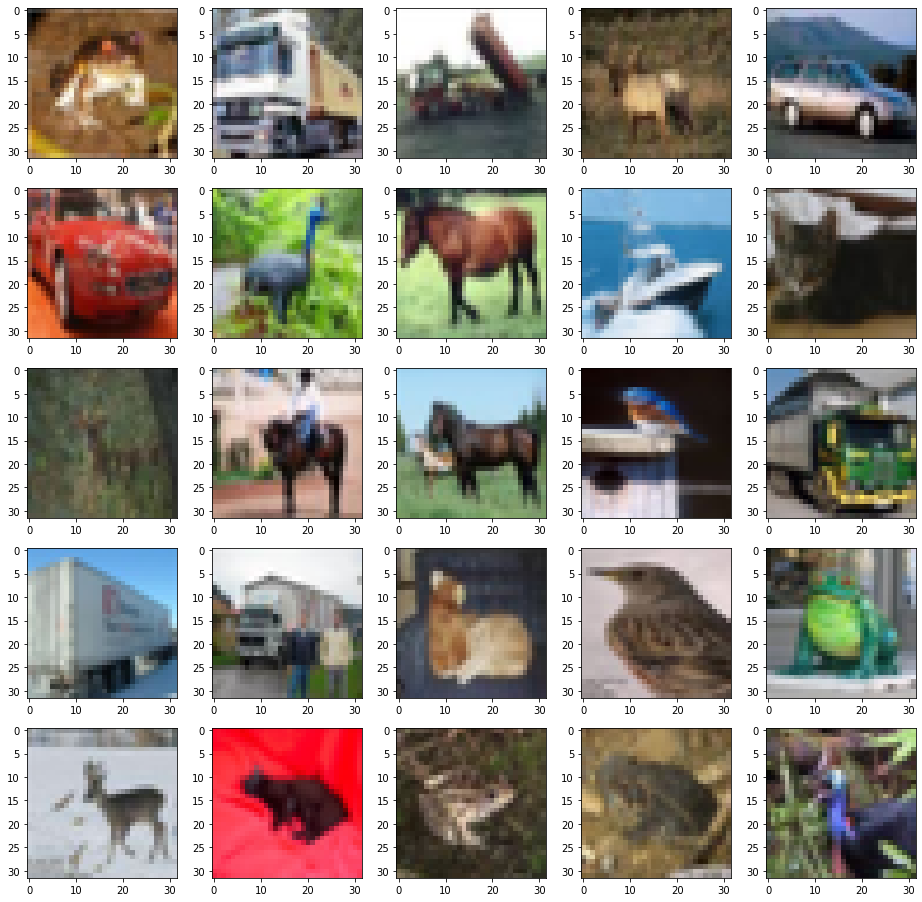

In [15]:
rows = 5
cols = 5
fig = plt.figure(figsize=(16, 16))
for i in range(cols * rows):
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(train_data[i])
plt.show()
    

### Define CNN Model with Keras

In [16]:
model = tf.keras.models.Sequential()
# First conv layer
model.add(tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(32,32,3)))
model.add(tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))

# Second conv layer
model.add(tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))

# Third conv layer
model.add(tf.keras.layers.Conv2D(128, (3,3), padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(128, (3,3), padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(128, (3,3), padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

# Flatten the model
model.add(tf.keras.layers.Flatten())
# Dense layer
model.add(tf.keras.layers.Dense(2048, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(2, activation="softmax"))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

### Compile & train the model

In [ ]:
# Specify the training configuration (optimizer, loss, metrics)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),  
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_data, train_labels, epochs=20, validation_data=(test_data, test_labels))

Train on 300000 samples, validate on 10000 samples
Epoch 1/20
241536/300000 [=======================>......] - ETA: 3:20 - loss: 0.3312 - accuracy: 0.8571

### Plot the results

In [0]:
plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower left')

final_loss, final_acc = model.evaluate(test_data, test_labels, verbose=2)

In [0]:
print(final_acc)
print(final_loss)